# Benchmarking UniVI using CITE-seq data

Andrew Ashford, Pathways + Omics Group, Oregon Health & Science University - 11/18/2025

This Jupyter Notebook will be used to benchmark UniVI models trained using Hao CITE-seq human PBMC data.


#### Import modules

In [3]:
# 0. Imports
import os, sys, json
import numpy as np
import scanpy as sc
import torch

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from univi import (
    UniVIMultiModalVAE,
    ModalityConfig,
    UniVIConfig,
    TrainingConfig,
    matching,
)
from univi.data import MultiModalDataset
from univi.trainer import UniVITrainer


In [4]:
import torch
print("Torch:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Torch: 2.4.1+cu121
torch.version.cuda: 12.1
CUDA available: True
Using device: cuda


#### Read in and preprocess data

In [5]:
# -------------------------
# 1. Load AnnData objects
# -------------------------
# Load RNA AnnData object
rna_adata = sc.read_h5ad("../data/Hao_CITE-seq_data/Hao_RNA_data.h5ad")



/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [6]:
# Change the RNA counts to raw counts so they're not log-normalized and use ZINB or NB as the decoder distribution
# for model training
rna_adata.layers['log1p'] = rna_adata.X
rna_adata.X = rna_adata.raw.X


In [7]:
# If your counts are in rna_adata.X (raw or log-normalized), this is fine:
sc.pp.highly_variable_genes(
    rna_adata,
    layer='log1p',
    n_top_genes=2000,
    flavor="seurat",   # or "cell_ranger" / "seurat_v3"
    inplace=True,
)


In [8]:
# Boolean mask of HVGs
hvg_mask = rna_adata.var["highly_variable"].values

# Names of the top HVGs
hvg_genes = rna_adata.var_names[hvg_mask].tolist()
print(f"Selected {len(hvg_genes)} highly variable genes.")
print(hvg_genes[:20])  # peek at first few


Selected 2000 highly variable genes.
['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'RBP7', 'EPHA2', 'PADI4', 'CDA', 'EIF4G3', 'AL031005.1', 'C1QA', 'C1QC', 'C1QB', 'TCEA3', 'ID3', 'RCAN3', 'LDLRAP1', 'STMN1', 'ZNF683', 'IFI6']


In [9]:
# Optional: make a HVG-only AnnData for modeling
rna_adata_hvg = rna_adata[:, hvg_mask].copy()
print(rna_adata_hvg)


AnnData object with n_obs × n_vars = 161764 × 2000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'hvg'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    layers: 'log1p'
    obsp: 'distances'


In [10]:
# Load ADT AnnData object
adt_adata = sc.read_h5ad("../data/Hao_CITE-seq_data/Hao_ADT_data.h5ad")


In [11]:
# Set the ADT data to raw counts and use a NB or ZINB decoder in model training and save the current .X counts to
# .layers['log1p']
adt_adata.layers['log1p'] = adt_adata.X
adt_adata.X = adt_adata.raw.X


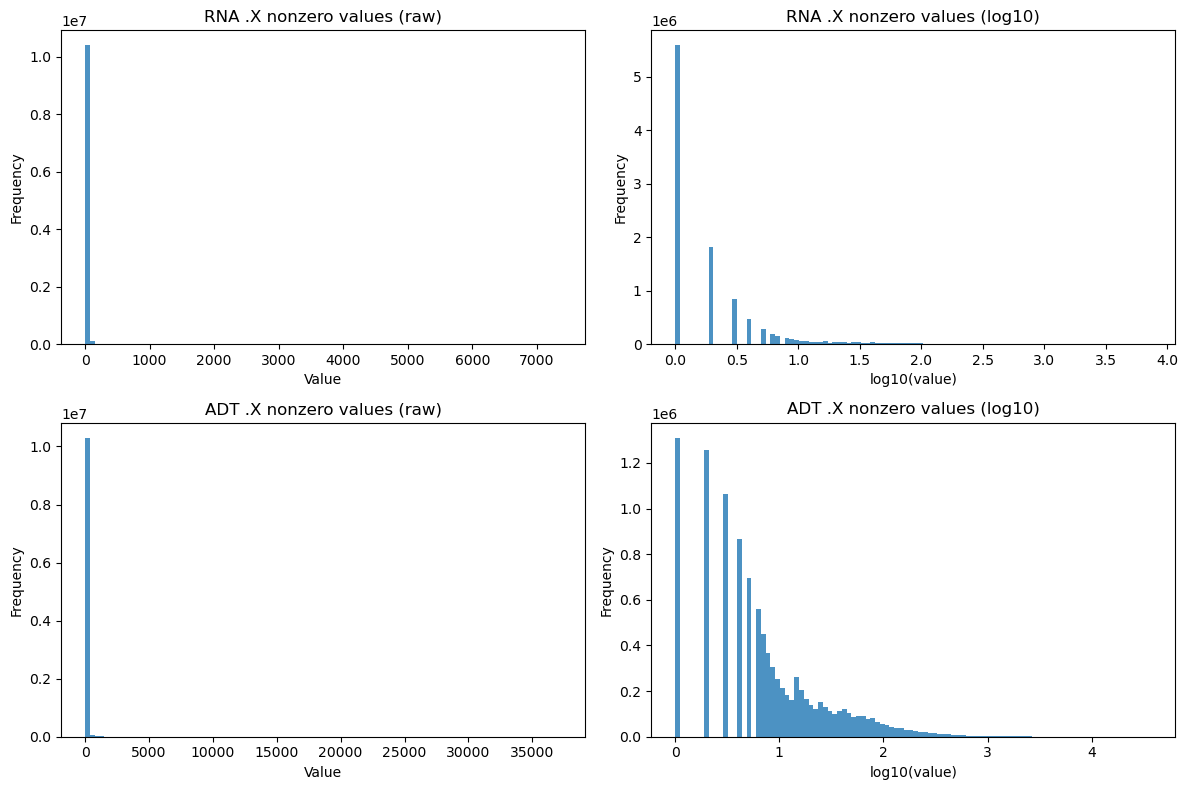

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

def get_X_values(adata, n_cells: int = 5000):
    """
    Return flattened values from adata.X (optionally subsampled over cells).
    Uses only non-zero entries if X is sparse.
    """
    X = adata.X

    # Optional subsampling over cells (rows)
    if n_cells is not None and adata.n_obs > n_cells:
        idx = np.random.choice(adata.n_obs, size=n_cells, replace=False)
        X = X[idx]

    if sparse.issparse(X):
        vals = X.data  # nonzero values
    else:
        vals = np.asarray(X).ravel()

    # Remove zeros explicitly (just to focus on count/ADT magnitude)
    vals = vals[vals > 0]
    return vals

def plot_X_distribution(rna_adata, adt_adata, n_cells: int = 5000):
    rna_vals = get_X_values(rna_adata, n_cells=n_cells)
    adt_vals = get_X_values(adt_adata, n_cells=n_cells)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # --- RNA raw ---
    axes[0, 0].hist(rna_vals, bins=100, alpha=0.8)
    axes[0, 0].set_title("RNA .X nonzero values (raw)")
    axes[0, 0].set_xlabel("Value")
    axes[0, 0].set_ylabel("Frequency")

    # --- RNA log10 ---
    axes[0, 1].hist(np.log10(rna_vals + 1e-8), bins=100, alpha=0.8)
    axes[0, 1].set_title("RNA .X nonzero values (log10)")
    axes[0, 1].set_xlabel("log10(value)")
    axes[0, 1].set_ylabel("Frequency")

    # --- ADT raw ---
    axes[1, 0].hist(adt_vals, bins=100, alpha=0.8)
    axes[1, 0].set_title("ADT .X nonzero values (raw)")
    axes[1, 0].set_xlabel("Value")
    axes[1, 0].set_ylabel("Frequency")

    # --- ADT log10 ---
    axes[1, 1].hist(np.log10(adt_vals + 1e-8), bins=100, alpha=0.8)
    axes[1, 1].set_title("ADT .X nonzero values (log10)")
    axes[1, 1].set_xlabel("log10(value)")
    axes[1, 1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Call it:
plot_X_distribution(rna_adata_hvg, adt_adata, n_cells=50000)


In [13]:
print(rna_adata_hvg)
print(set(rna_adata_hvg.obs['celltype.l1']))
print(rna_adata_hvg.obs['celltype.l1'].value_counts())
print(set(rna_adata_hvg.obs['celltype.l2']))
print(rna_adata_hvg.obs['celltype.l2'].value_counts())
print(set(rna_adata_hvg.obs['celltype.l3']))
print(rna_adata_hvg.obs['celltype.l3'].value_counts())


AnnData object with n_obs × n_vars = 161764 × 2000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'hvg'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    layers: 'log1p'
    obsp: 'distances'
{'CD4 T', 'CD8 T', 'B', 'other T', 'DC', 'Mono', 'other', 'NK'}
Mono       49010
CD4 T      41001
CD8 T      25469
NK         18664
B          13800
other T     6789
DC          3589
other       3442
Name: celltype.l1, dtype: int64
{'HSPC', 'CD8 TEM', 'CD8 Proliferating', 'Eryth', 'CD14 Mono', 'CD16 Mono', 'gdT', 'pDC', 'ILC', 'B intermediate', 'Treg', 'Plasmablast', 'B naive', 'CD4 Proliferating', 'cDC2', 'cDC1', 'NK Proliferating', 'CD8 TCM', 'Doublet', 'Platelet', 'dnT', 'NK', 'CD8 Naive', 'NK_CD56br

#### Specify any additional helper functions

In [14]:
def train_univi_model(
    rna_adata_hvg,
    adt_adata,
    train_cfg,
    likelihood_rna="nb",
    likelihood_adt="zinb",
    seed=0,
):
    torch.manual_seed(seed)
    np.random.seed(seed)

    modality_cfgs = [
        ModalityConfig(
            name="rna",
            input_dim=rna_adata_hvg.n_vars,
            encoder_hidden=[512, 256],
            decoder_hidden=[256, 512],
            likelihood=likelihood_rna,
        ),
        ModalityConfig(
            name="adt",
            input_dim=adt_adata.n_vars,
            encoder_hidden=[128, 64],
            decoder_hidden=[64, 128],
            likelihood=likelihood_adt,
        ),
    ]

    univi_cfg = UniVIConfig(
        latent_dim=40,
        modalities=modality_cfgs,
        beta=80.0,
        gamma=120.0,
        encoder_dropout=0.0,
        encoder_batchnorm=True,
        decoder_dropout=0.0,
        decoder_batchnorm=False,
        kl_anneal_start=0,
        kl_anneal_end=0,
        align_anneal_start=0,
        align_anneal_end=0,
    )

    model = UniVIMultiModalVAE(univi_cfg).to(train_cfg.device)

    trainer = UniVITrainer(
        model=model,
        train_loader=train_loader,  # from your earlier split code
        val_loader=val_loader,
        train_cfg=train_cfg,
        device=train_cfg.device,
    )

    history = trainer.fit()
    return model, trainer, history


#### Load data with data loaders for training/validation/test/unused sets

In [15]:
train_cfg = TrainingConfig(
    n_epochs=200,
    batch_size=512,
    lr=1e-3,
    weight_decay=1e-4,
    device=device,
    log_every=10,
    grad_clip=5.0,
    num_workers=0,
    seed=42,
    early_stopping=True,
    patience=20,
    min_delta=0.0,
)


In [16]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from univi.data import MultiModalDataset

# --------------------------------------------------
# 0. Sanity check: RNA / ADT are already aligned
# --------------------------------------------------
assert rna_adata_hvg.n_obs == adt_adata.n_obs, "RNA and ADT have different #cells"
assert np.array_equal(rna_adata_hvg.obs_names, adt_adata.obs_names), (
    "RNA and ADT obs_names are not aligned – align them first."
)

print(f"Total paired cells BEFORE subsampling: {rna_adata_hvg.n_obs}")

# --------------------------------------------------
# 1. Per-celltype subsampling for balance
# --------------------------------------------------
celltype_key = "celltype.l2"
max_per_type = 1000

labels = rna_adata_hvg.obs[celltype_key].astype(str).values
unique_ct = np.unique(labels)

rng = np.random.default_rng(train_cfg.seed)

selected_indices_list = []
for ct in unique_ct:
    idx_ct = np.where(labels == ct)[0]
    if len(idx_ct) == 0:
        continue
    if len(idx_ct) > max_per_type:
        chosen = rng.choice(idx_ct, size=max_per_type, replace=False)
    else:
        chosen = idx_ct
    selected_indices_list.append(chosen)

selected_indices = np.concatenate(selected_indices_list)
rng.shuffle(selected_indices)

n_cells = len(selected_indices)
print(f"Total paired cells AFTER per-celltype cap: {n_cells}")

# --------------------------------------------------
# 2. Build MultiModalDataset (full, indices will subset)
# --------------------------------------------------
adata_by_mod = {"rna": rna_adata_hvg, "adt": adt_adata}

full_dataset = MultiModalDataset(
    adata_dict=adata_by_mod,
    X_key="X",                # or your desired layer/key
    device=train_cfg.device,
)

# --------------------------------------------------
# 3. Train / val / test splits on selected_indices
# --------------------------------------------------
frac_train = 0.8
frac_val   = 0.1

n_train = int(frac_train * n_cells)
n_val   = int(frac_val   * n_cells)

train_idx = selected_indices[:n_train]
val_idx   = selected_indices[n_train:n_train + n_val]
test_idx  = selected_indices[n_train + n_val:]

print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)

train_loader = DataLoader(
    train_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=True,
    num_workers=train_cfg.num_workers,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=False,
    num_workers=train_cfg.num_workers,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=False,
    num_workers=train_cfg.num_workers,
)

# --------------------------------------------------
# 4. Mark splits + unused cells for later reference
# --------------------------------------------------
def init_split_column(adata, col="univi_split"):
    if col not in adata.obs.columns:
        adata.obs[col] = "unused"

init_split_column(rna_adata, "univi_split")
init_split_column(adt_adata, "univi_split")

# start everything as unused
rna_adata.obs["univi_split"] = "unused"
adt_adata.obs["univi_split"] = "unused"

# mark train / val / test
rna_adata.obs.iloc[train_idx, rna_adata.obs.columns.get_loc("univi_split")] = "train"
rna_adata.obs.iloc[val_idx,   rna_adata.obs.columns.get_loc("univi_split")] = "val"
rna_adata.obs.iloc[test_idx,  rna_adata.obs.columns.get_loc("univi_split")] = "test"

adt_adata.obs.iloc[train_idx, adt_adata.obs.columns.get_loc("univi_split")] = "train"
adt_adata.obs.iloc[val_idx,   adt_adata.obs.columns.get_loc("univi_split")] = "val"
adt_adata.obs.iloc[test_idx,  adt_adata.obs.columns.get_loc("univi_split")] = "test"

rna_train_adata = rna_adata[rna_adata.obs["univi_split"] == "train"].copy()
rna_val_adata   = rna_adata[rna_adata.obs["univi_split"] == "val"].copy()
rna_test_adata  = rna_adata[rna_adata.obs["univi_split"] == "test"].copy()
rna_unused      = rna_adata[rna_adata.obs["univi_split"] == "unused"].copy()

adt_train_adata = adt_adata[adt_adata.obs["univi_split"] == "train"].copy()
adt_val_adata   = adt_adata[adt_adata.obs["univi_split"] == "val"].copy()
adt_test_adata  = adt_adata[adt_adata.obs["univi_split"] == "test"].copy()
adt_unused      = adt_adata[adt_adata.obs["univi_split"] == "unused"].copy()

print(
    "RNA split sizes:",
    {k: v.n_obs for k, v in dict(
        train=rna_train_adata,
        val=rna_val_adata,
        test=rna_test_adata,
        unused=rna_unused,
    ).items()},
)
print(
    "ADT split sizes:",
    {k: v.n_obs for k, v in dict(
        train=adt_train_adata,
        val=adt_val_adata,
        test=adt_test_adata,
        unused=adt_unused,
    ).items()},
)


Total paired cells BEFORE subsampling: 161764
Total paired cells AFTER per-celltype cap: 22649
Train: 18119, Val: 2264, Test: 2266
RNA split sizes: {'train': 18119, 'val': 2264, 'test': 2266, 'unused': 139115}
ADT split sizes: {'train': 18119, 'val': 2264, 'test': 2266, 'unused': 139115}


#### Set up model configs/loaders

In [17]:
models = {}
histories = {}

for tag, (lik_rna, lik_adt) in {
    "gaussian": ("gaussian", "gaussian"),
    "nb":       ("nb",       "nb"),
    "zinb":     ("nb",       "zinb"),  # RNA NB, ADT ZINB
}.items():
    print(f"\n=== Training UniVI ({tag}) ===")
    model, trainer, history = train_univi_model(
        rna_adata_hvg,
        adt_adata,
        train_cfg,
        likelihood_rna=lik_rna,
        likelihood_adt=lik_adt,
        seed=42,
    )
    models[tag] = (model, trainer)
    histories[tag] = history



=== Training UniVI (gaussian) ===


[2025-11-19 19:52:46,654] [UniVITrainer] [INFO] TrainingConfig:
[2025-11-19 19:52:46,659] [UniVITrainer] [INFO]   n_epochs: 200
[2025-11-19 19:52:46,663] [UniVITrainer] [INFO]   batch_size: 512
[2025-11-19 19:52:46,667] [UniVITrainer] [INFO]   lr: 0.001
[2025-11-19 19:52:46,670] [UniVITrainer] [INFO]   weight_decay: 0.0001
[2025-11-19 19:52:46,673] [UniVITrainer] [INFO]   device: cuda
[2025-11-19 19:52:46,677] [UniVITrainer] [INFO]   log_every: 10
[2025-11-19 19:52:46,680] [UniVITrainer] [INFO]   grad_clip: 5.0
[2025-11-19 19:52:46,681] [UniVITrainer] [INFO]   num_workers: 0
[2025-11-19 19:52:46,682] [UniVITrainer] [INFO]   seed: 42
[2025-11-19 19:52:46,682] [UniVITrainer] [INFO]   early_stopping: True
[2025-11-19 19:52:46,683] [UniVITrainer] [INFO]   patience: 20
[2025-11-19 19:52:46,684] [UniVITrainer] [INFO]   min_delta: 0.0


Training UniVI:   0%|          | 0/200 [00:00<?, ?it/s]

[2025-11-19 19:53:00,238] [UniVITrainer] [INFO] [Epoch 001] Train loss: 4534053.8889 (beta=80.000, gamma=120.000)
[2025-11-19 19:53:01,108] [UniVITrainer] [INFO] [Epoch 001] Val loss: 3999032.1000 (beta=80.000, gamma=120.000)
[2025-11-19 19:53:01,206] [UniVITrainer] [INFO] [Epoch 001] New best val loss: 3999032.1000
[2025-11-19 19:53:10,654] [UniVITrainer] [INFO] [Epoch 002] New best val loss: 3007444.0500
[2025-11-19 19:53:19,366] [UniVITrainer] [INFO] [Epoch 003] New best val loss: 2437649.7500
[2025-11-19 19:53:29,648] [UniVITrainer] [INFO] [Epoch 004] New best val loss: 2351762.5500
[2025-11-19 19:53:39,958] [UniVITrainer] [INFO] [Epoch 005] New best val loss: 2268334.2500
[2025-11-19 19:53:50,222] [UniVITrainer] [INFO] [Epoch 006] New best val loss: 1986590.9750
[2025-11-19 19:53:59,610] [UniVITrainer] [INFO] [Epoch 007] New best val loss: 1639509.2500
[2025-11-19 19:54:07,252] [UniVITrainer] [INFO] [Epoch 008] New best val loss: 1494605.7750
[2025-11-19 19:54:17,103] [UniVITraine

[2025-11-19 20:11:38,595] [UniVITrainer] [INFO] [Epoch 090] Train loss: 295970.6771 (beta=80.000, gamma=120.000)
[2025-11-19 20:11:40,811] [UniVITrainer] [INFO] [Epoch 090] Val loss: 179855.1969 (beta=80.000, gamma=120.000)
[2025-11-19 20:11:40,985] [UniVITrainer] [INFO] [Epoch 090] New best val loss: 179855.1969
[2025-11-19 20:12:26,690] [UniVITrainer] [INFO] [Epoch 092] New best val loss: 174570.5844
[2025-11-19 20:13:17,477] [UniVITrainer] [INFO] [Epoch 094] New best val loss: 172760.9062
[2025-11-19 20:13:37,079] [UniVITrainer] [INFO] [Epoch 095] New best val loss: 170983.5187
[2025-11-19 20:14:17,824] [UniVITrainer] [INFO] [Epoch 097] New best val loss: 168121.9969
[2025-11-19 20:15:15,070] [UniVITrainer] [INFO] [Epoch 100] Train loss: 283072.2478 (beta=80.000, gamma=120.000)
[2025-11-19 20:15:17,207] [UniVITrainer] [INFO] [Epoch 100] Val loss: 175495.4062 (beta=80.000, gamma=120.000)
[2025-11-19 20:15:56,905] [UniVITrainer] [INFO] [Epoch 102] New best val loss: 166522.3250
[2025-

In [ ]:
torch.save(model.state_dict(), f"univi_{tag}_benchmarking_best.pt")


#### Evaluation on test set

In [ ]:
import scipy.sparse as sp

def encode_full_latents(model, trainer, rna_adata, adt_adata, batch_size=1024):
    model.eval()
    device = trainer.device

    def _encode(adata, modality):
        X = adata.X
        if sp.issparse(X):
            X = X.toarray()
        X_t = torch.as_tensor(X, dtype=torch.float32, device=device)

        zs = []
        for start in range(0, X_t.shape[0], batch_size):
            xb = X_t[start:start+batch_size]
            mu_dict, logvar_dict = model.encode_modalities({modality: xb})
            mu_z, logvar_z = model.mixture_of_experts(
                {modality: mu_dict[modality]},
                {modality: logvar_dict[modality]},
            )
            zs.append(mu_z.detach().cpu().numpy())
        return np.vstack(zs)

    z_rna = _encode(rna_adata, "rna")
    z_adt = _encode(adt_adata, "adt")
    return z_rna, z_adt


In [ ]:
from univi import evaluation as univi_eval
from univi import plotting as univi_plot

results = []

for tag, (model, trainer) in models.items():
    print(f"\n=== Eval: {tag} ===")

    # 1. Latents
    z_rna, z_adt = encode_full_latents(model, trainer, rna_test_adata, adt_test_adata)

    # 2. FOSCTTM
    fos = univi_eval.compute_foscttm(z_rna, z_adt)
    print(f"FOSCTTM: {fos:.4f}")

    # 3. Modality mixing
    Z_joint = np.concatenate([z_rna, z_adt], axis=0)
    mods = np.array(["rna"] * z_rna.shape[0] + ["adt"] * z_adt.shape[0])
    mix = univi_eval.compute_modality_mixing(Z_joint, mods, k=20)
    print(f"Mixing score (k=20): {mix:.3f}")

    # 4. Label transfer (ADT → RNA on test)
    labels_rna = rna_test_adata.obs["celltype.l2"].astype(str).values
    labels_adt = adt_test_adata.obs["celltype.l2"].astype(str).values

    pred_rna_from_adt, acc_rna, cm_rna = univi_eval.label_transfer_knn(
        Z_source=z_adt,
        labels_source=labels_adt,
        Z_target=z_rna,
        labels_target=labels_rna,
        k=15,
    )
    print(f"Label transfer acc (ADT→RNA, test, k=15): {acc_rna:.3f}")

    # 5. Cross-modal reconstruction: RNA→ADT (test set)
    model.eval()
    with torch.no_grad():
        X_rna = rna_test_adata.X
        if sp.issparse(X_rna):
            X_rna = X_rna.toarray()
        X_rna_t = torch.as_tensor(X_rna, dtype=torch.float32, device=trainer.device)

        xhat_adt_list = []
        bs = 512
        for start in range(0, X_rna_t.shape[0], bs):
            xb = X_rna_t[start:start+bs]
            mu_dict, logvar_dict = model.encode_modalities({"rna": xb})
            mu_z, logvar_z = model.mixture_of_experts(
                {"rna": mu_dict["rna"]},
                {"rna": logvar_dict["rna"]},
            )
            xhat_raw = model.decode_modalities(mu_z)
            xhat_adt_list.append(xhat_raw["adt"].cpu().numpy())

        xhat_adt = np.vstack(xhat_adt_list)

    X_adt = adt_test_adata.X
    if sp.issparse(X_adt):
        X_adt = X_adt.toarray()

    mse_feat = univi_eval.mse_per_feature(X_adt, xhat_adt)
    corr_feat = univi_eval.pearson_corr_per_feature(X_adt, xhat_adt)

    print(f"ADT MSE (RNA→ADT, test): {mse_feat.mean():.4f}")
    print(f"ADT Pearson r (RNA→ADT, test): {corr_feat.mean():.3f}")

    results.append({
        "model": tag,
        "foscttm": float(fos),
        "mixing": float(mix),
        "label_acc": float(acc_rna),
        "adt_mse": float(mse_feat.mean()),
        "adt_corr": float(corr_feat.mean()),
    })


In [ ]:
import pandas as pd
results_df = pd.DataFrame(results)
results_df
